In [1]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from energy_rbm import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
# np.seterr(divide='ignore', invalid='ignore')


In [3]:
! nvidia-smi

Fri Mar 19 15:12:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 206...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    12W / 175W |    148MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:

CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0
 
if CUDA:
    torch.cuda.set_device(CUDA_DEVICE)
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
n_hid_range=[4, 8, 16, 32, 64]
# n_hid_range=[2, 128, 24, 48, 96]
# n_hid_range=[2]


n_vis=784
k=5
n_epochs=5001
batch_size=60
lr=0.01
vol=300

In [7]:
def transform_str_list(list0):
    list1=[]
    for i in range(len(list0)):    
        aa=np.array(list0[i].strip('][ tensor()').strip('\n').replace('\n','').split(', ')).astype(float)
        list1.append(aa)
    
    return torch.from_numpy(np.array(list1)).float()  

def get_first_Trues(idx, vol):
    i=0
    for k in range(len(idx)):
        if idx[k]==True:
            i=i+1
            if i>vol:
                idx[k:]=False
                break        
    return idx

def get_small_mnist(vol, train_or_test):
    if train_or_test=='train':
        dataset = datasets.MNIST(root='./data/mnist',train=True,
                                 transform=transforms.ToTensor())
    else:
        dataset = datasets.MNIST(root='./data/mnist',train=False,
                                 transform=transforms.ToTensor())
        
    dataset.targets = torch.tensor(dataset.targets)
#     idx = dataset.targets==0

    idx_list=[]
    for k in [0,1]:
        idx = dataset.targets==k
        idx = get_first_Trues(idx, vol)
        idx_list.append(idx)
    idx=sum(idx_list)
    idx2=[]
    for i in range(len(idx)):
        if idx[i]>=1:
            idx2.append(True)
        else:
            idx2.append(False)
    idx2=torch.tensor(idx2)
    dataset.targets= dataset.targets[idx2]
    dataset.data = dataset.data[idx2]
    return dataset

train_dataset = get_small_mnist(vol, 'train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
#     test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = get_small_mnist(1000, 'test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000)

In [8]:
def train_and_get_data(n_hid, vol, model, train_loader=train_loader, test_loader=test_loader):
    if model==0:
        rbm = RBM(n_vis, n_hid, k, use_cuda=True)
    else:
        rbm=model
        
#     train_op = optim.Adam(rbm.parameters(), lr)
    train_op = optim.SGD(rbm.parameters(), lr, momentum=0.9)

    # train the RBM model
    rbm.train()

    train_loss_list=[]
    test_loss_list=[]
    for epoch in tqdm(range(n_epochs)):

#     for epoch in range(n_epochs):
        train_loss_epoch = []
        test_loss_epoch = []
        for _, (data, target) in enumerate(train_loader):
            data=data.cuda()
            v, v_gibbs = rbm(data.view(-1, 784))
            train_loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
            train_loss_epoch.append(train_loss.item())
            train_op.zero_grad()
            train_loss.backward()
            train_op.step()
        for _, (data, target) in enumerate(test_loader):
            data=data.cuda()
            v, v_gibbs = rbm(data.view(-1, 784))
            test_loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
            test_loss_epoch.append(test_loss.item())
        train_loss_list.append(np.mean(train_loss_epoch))
        test_loss_list.append(np.mean(test_loss_epoch))
#         if epoch in [100, 1000, 10000, 100000]:
#             print("epoch : {epoch}".format(epoch=epoch))
        
    with open('ERBM,SGD/lr=0.01/loss/2021-01-28_loss_n_hid={n_hid}_vol={v}_epoch={ep}.pkl'.format(n_hid=n_hid, v=vol*2, ep=epoch), 'wb') as f:
        pkl.dump([train_loss_list, test_loss_list], f)
    torch.save(rbm, 'ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol={v}_epoch={ep}'.format(n_hid=n_hid, v=vol*2, ep=epoch))
    

In [222]:
for n_hid in n_hid_range:
    print(n_hid)
    train_and_get_data(n_hid, vol, model=torch.load('ERBM,SGD/lr=0.05/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=10000'.format(n_hid=n_hid))
                       ,train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/5001 [00:00<?, ?it/s]

4


  0%|          | 1/5001 [00:00<15:43,  5.30it/s]

8


  0%|          | 1/5001 [00:00<14:35,  5.71it/s]

16


  0%|          | 1/5001 [00:00<14:23,  5.79it/s]

32


  0%|          | 1/5001 [00:00<13:53,  6.00it/s]

64


100%|██████████| 5001/5001 [13:36<00:00,  6.12it/s]


In [10]:
def make_samples(model, n_sample=1000, step_eq=500):
    model=model.cpu()
    n_hid=len(model.h[0])
    step_eq=500
    v_samples=[]
    h_samples=[]
    encoded=[]
#     torch.cuda.empty_cache()
    train_dataset = get_small_mnist(6000, 'train')
    train_loader = torch.utils.data.DataLoader(train_dataset, 1)
    for _, (data, target) in enumerate(train_loader):
#         data=data.cuda()
        encoded_sample = model.visible_to_hidden(data.view(-1, 784))
        encoded_sample = encoded_sample.bernoulli()
        encoded.append(str(encoded_sample.detach().cpu()))
    with open('ERBM,SGD/lr=0.01/encoded/2021-01-28_encoded2_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(encoded, f)
        
    for n in tqdm(range(n_sample)):
#     for n in range(n_sample):
        input_random=torch.round(torch.rand(n_hid).view(1, n_hid))
        for i in range(step_eq):
            v_sample=model.hidden_to_visible(input_random)
            v_sample=v_sample.bernoulli()
            h_sample=model.visible_to_hidden(v_sample)
            h_sample=h_sample.bernoulli()
            input_random=h_sample
        v_sample=model.hidden_to_visible(h_sample)
#         v_samples.append(v_sample.view(1,28,28))
        v_samples.append(np.reshape(v_sample.tolist(),(28,28)))
        h_samples.append(str(h_sample.detach().cpu()))
    with open('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(v_samples, f)
    with open('ERBM,SGD/lr=0.01/encoded/2021-01-28_encoded_n_hid={n_hid}_vol=600_epoch=5000.pkl'.format(n_hid=n_hid), 'wb') as f:
        pkl.dump(h_samples, f)


In [9]:
# n_hid_range=[2]

model_list=[]
for i in n_hid_range:
    model_list.append(torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=i)))
for i in range(len(model_list)):
    make_samples(model_list[i], n_sample=1000, step_eq=500)

NameError: name 'make_samples' is not defined

In [11]:
model_list=[]
for i in n_hid_range:
    model_list.append(torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=i)))


In [20]:
a=model_list[4].h.detach().cpu()
a=np.squeeze(a.numpy())
with open('n_hid=64_vol_12000_h.pkl', 'wb') as f:
    pkl.dump(a, f)

In [12]:
def IG_loss(model0, model1, data0, v_sample0):
    E0=0; E1=0
    F_V = model0.free_energy(data0)

    v_sample0=torch.tensor(v_sample0)
    for i in range(len(v_sample0)):
        E0 += model0.energy(v_sample0[i])/len(v_sample0)
        E1 += model1.energy(v_sample0[i])/len(v_sample0)
    return float(F_V), float(E1), float(E0)

In [75]:
def check_energy(model0, model1, n_sample=10000, step_eq=500):
    E0_list=[]; E1_list=[]
    v_list=[]
    input_random=torch.round(torch.rand(n_vis).view(1, n_vis)).cuda()
    for i in range(step_eq):
        h_sample=model0.visible_to_hidden(input_random)
        h_sample=h_sample.bernoulli()
        v_sample=model0.hidden_to_visible(h_sample)
        v_sample=v_sample.bernoulli()
        input_random=v_sample
    for n in tqdm(range(n_sample)):
        h_sample=model0.visible_to_hidden(v_sample)
        h_sample=h_sample.bernoulli()
        v_sample=model0.hidden_to_visible(h_sample)
        v_list.append(np.squeeze(v_sample.detach().cpu().numpy()))
        v_sample=v_sample.bernoulli()
        E0_list.append(np.squeeze(model0.energy(v_sample).detach().cpu().numpy()))
        E1_list.append(np.squeeze(model1.energy(v_sample).detach().cpu().numpy()))
    return np.array(E0_list), np.array(E1_list), np.array(E1_list)-np.array(E0_list), v_list

#         v_samples.append(v_sample.view(1,28,28))
#     v_samples.append(np.reshape(v_sample.tolist(),(28,28)))
    
    
#     E_list=[]
#     v_sample0=torch.tensor(v_sample0)
#     for i in range(len(v_sample0)):
#         E_list.append(model0.energy(v_sample0[i]))
#     print('max:{max0}, min:{min0}'.format(max0=float(max(E_list)), min0=float(min(E_list))))
#     return max(E_list), min(E_list)

In [79]:
n_hid=16
step_eq=1
model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid)).float()
model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid)).float()

n_hid_energy=check_energy(model0, model1, n_sample=100000, step_eq=step_eq)


100%|██████████| 100000/100000 [01:02<00:00, 1610.12it/s]


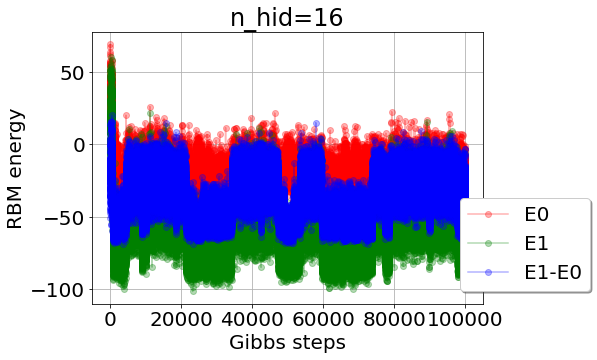

In [80]:

plt.figure(figsize=(7,5))
plt.plot(range(len(n_hid_energy[0])), list(n_hid_energy[0]), '-o', color='red', alpha=0.3)
plt.plot(range(len(n_hid_energy[1])), list(n_hid_energy[1]), '-o', color='green', alpha=0.3)
plt.plot(range(len(n_hid_energy[2])), list(n_hid_energy[2]), '-o', color='blue', alpha=0.3)
plt.grid(True)
plt.xlabel('Gibbs steps', fontsize=20)
plt.ylabel('RBM energy', fontsize=20)
# plt.title('n_hid={n_hid}, eq={step_eq}'.format(n_hid=n_hid, step_eq=step_eq))
plt.title('n_hid={n_hid}'.format(n_hid=n_hid))
plt.legend(['E0', 'E1', 'E1-E0'],
           loc='lower right', bbox_to_anchor=(1.3, 0.01), 
           ncol=1, fancybox=True, shadow=True)

# plt.text(350, 0.1, '~$k^{2.1}$ ', fontsize=20)
plt.rcParams["font.size"] = "20"
# plt.axis([2**5, 2**9, 0, 16])
# plt.savefig('image/IEvsn_hid.png', pad_inches=10)
plt.plot()
plt.show()


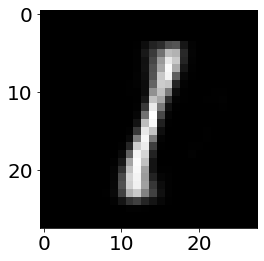

In [140]:
plt.imshow(n_hid_energy[3][90000].reshape(28,28), cmap="gray")


In [139]:
n_hid_energy[2][90000]

-40.06088

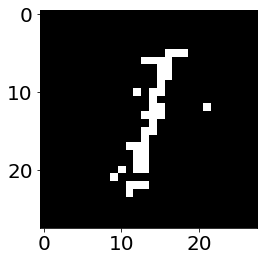

In [141]:
aaaaa=torch.tensor(n_hid_energy[3][90000]).bernoulli().numpy()
plt.imshow(aaaaa.reshape(28,28), cmap="gray")


In [142]:
dataset0=torch.tensor(pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid=16_vol=12000_epoch=5000.pkl')).cuda()
Elist=[]
model3=model_list[0].cuda()
for i in range(len(dataset0)):
#     Elist.append(model3.energy(dataset0[i].view(784).float()))
    Elist.append(np.squeeze(model3.energy(dataset0[i]).detach().cpu().numpy()))

plt.figure(figsize=(7,5))
plt.plot(range(len(dataset0)), list(dataset0), '-o', color='red', alpha=0.01)
plt.grid(True)
plt.xlabel('Gibbs steps', fontsize=20)
plt.ylabel('RBM energy', fontsize=20)
# plt.title('n_hid={n_hid}, eq={step_eq}'.format(n_hid=n_hid, step_eq=step_eq))
plt.title('n_hid={n_hid}'.format(n_hid=n_hid))
plt.legend(['E0', 'E1', 'E1-E0'],
           loc='lower right', bbox_to_anchor=(1.3, 0.01), 
           ncol=1, fancybox=True, shadow=True)

# plt.text(350, 0.1, '~$k^{2.1}$ ', fontsize=20)
plt.rcParams["font.size"] = "20"
# plt.axis([2**5, 2**9, 0, 16])
# plt.savefig('image/IEvsn_hid.png', pad_inches=10)
plt.plot()
plt.show()


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [123]:
dataset0[0].view(784)

tensor([1.9923e-06, 5.0812e-07, 7.3575e-07, 1.0632e-06, 7.0465e-07, 1.5801e-06,
        6.2873e-07, 8.3157e-07, 2.5135e-06, 8.0698e-07, 6.6314e-07, 1.2970e-06,
        8.2145e-07, 9.8472e-07, 6.6672e-07, 1.8612e-06, 8.2392e-07, 9.0741e-07,
        1.1278e-06, 1.0670e-06, 5.8532e-07, 8.3830e-07, 1.1430e-06, 1.8194e-06,
        2.3790e-06, 1.1508e-06, 1.1861e-06, 1.5200e-06, 1.2161e-06, 6.1265e-07,
        4.9095e-07, 4.5380e-07, 9.3493e-07, 4.0988e-07, 1.1363e-06, 1.6188e-06,
        2.0723e-06, 5.4739e-07, 4.2006e-07, 1.8109e-04, 2.1222e-04, 2.0062e-04,
        9.6440e-06, 1.6200e-04, 1.0325e-04, 2.6893e-05, 1.3143e-06, 1.0681e-06,
        1.7023e-06, 5.0245e-07, 1.3769e-06, 5.5856e-07, 7.3120e-07, 1.0724e-06,
        5.4086e-07, 5.7380e-07, 1.0359e-06, 1.1292e-06, 1.6652e-06, 7.2050e-05,
        1.5019e-05, 5.9343e-07, 7.0278e-05, 5.1956e-04, 1.1256e-04, 1.5812e-06,
        1.0525e-06, 3.0400e-04, 4.5800e-04, 6.5657e-04, 4.9594e-04, 3.2395e-04,
        1.0042e-03, 1.2015e-03, 2.2840e-

In [94]:
model_list[0].visible_to_hidden(torch.tensor(n_hid_energy[3][90000]).cuda().view(1,784))

tensor([[2.5656e-12, 1.0000e+00, 1.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [120]:
model_list[0].energy(torch.tensor(n_hid_energy[3][50000]).cuda().view(1,784))

tensor([[-77.7591]], device='cuda:0', grad_fn=<AddBackward0>)

In [84]:
def stround(x):
    c = np.floor(x)
    return c + ((x - c) > np.random.rand())


In [108]:
stround([0.9, 0.5, 0.1])

array([1., 0., 0.])

$
\left\langle F_V \right\rangle _{q_{V}} + \left\langle E'_{VH}-E_{VH} \right\rangle _{P_{VH}}-F'
$


In [19]:
n_hid_range=[4, 8, 16, 32, 64]
for n_hid in n_hid_range:
    print('n_hid={n_hid}'.format(n_hid=n_hid))
    model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid)).float()
    v_sample0=torch.tensor(np.reshape(pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=12000_epoch=5000.pkl'.format(n_hid=n_hid)), (1000, 1, 784))).cuda().float()

    check_energy(model0, v_sample0)

n_hid=4
max:89.69696044921875, min:-16.539966583251953
n_hid=8
max:178.9167022705078, min:87.54429626464844
n_hid=16
max:34.393798828125, min:-80.123291015625
n_hid=32
max:115.65156555175781, min:-13.658447265625
n_hid=64
max:187.50131225585938, min:67.38631439208984


In [44]:
data0=get_small_mnist(6000, 'train')
data0=(get_small_mnist(6000, 'train').data.view(len(data0.data),784)/255.).cuda()
for n_hid in n_hid_range:
    model0=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=12000_epoch=5000'.format(n_hid=n_hid)).float()
    model1=torch.load('ERBM,SGD/lr=0.01/models/2021-01-28_n_hid={n_hid}_vol=600_epoch=5000'.format(n_hid=n_hid)).float()

    v_sample0=torch.tensor(np.reshape(pd.read_pickle('ERBM,SGD/lr=0.01/samples/2021-01-28_samples2_n_hid={n_hid}_vol=12000_epoch=5000.pkl'.format(n_hid=n_hid)), (1000, 1, 784))).cuda().float()
    
    print('n_hid={n_hid}, IG_loss={IG_loss}'.format(n_hid=n_hid, IG_loss=IG_loss(model0, model1, data0, v_sample0)))

n_hid=4, IG_loss=(-27.35398292541504, 39.349266052246094, 58.01517868041992)
n_hid=8, IG_loss=(-136.95103454589844, 62.85564422607422, 153.4291534423828)
n_hid=16, IG_loss=(25.486005783081055, 41.09246063232422, 1.4457576274871826)
n_hid=32, IG_loss=(-26.709373474121094, 45.54371643066406, 84.99322509765625)
n_hid=64, IG_loss=(-115.40055847167969, 83.30638885498047, 132.1706085205078)
